# Homework 07

### Preparation...

Run this code from the lecture to be ready for the exercises below!

In [1]:
import glob
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

In [2]:
CONFIG_FILE = 'C:/ .. /entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [3]:
os.getcwd()
os.path.exists(CONFIG_FILE)

True

In [4]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(download_dir)

Concatenating 68 csv files...
Loading done.


In [29]:
def get_hourly_country_data(data, country):
    ret_data = data[data["AreaName"] == country].interpolate()
    # ret_data = ret_data.set_index("DateTime")
    ret_data = ret_data.resample("1h").mean().interpolate()
    return ret_data

power_demand_at_hourly = get_hourly_country_data(power_demand, "Austria")["2015-01-01":"2019-12-31"]

## Exercise 1

Explain the following terms:

**Input feature:** input values used for training 

**Output feature:** values that are predicted by the algorithm

**Fit a function to data:** minimize residuals sum of squares

**Training data:** part of the data that is used to train the algorithm; ~80% of data points

**Test data:** part of the data to see how well the fitted function predicts; 20%


    

## Exercise 2

In lecture07 we created a plot of the ratio of actual load and predicted load for Austria step by step (Exercise 04). Now put all of this together in one function which takes one parameter `country` as input and calculates and plots the figure of Exercise 04 for this country! The model should be trained on 2015-2019 data and then you should predict for 2020 and compare it to observations. Also do a training/test split and print the R2 for both datasets.

Apply the function to the following countries and show the results in one plot: Austria, Germany, Switzerland, Italy, Spain, Sweden, United Kingdom.

(1) Print the country name. Get the data for the specific country using ```get_hourly_country_data``` from the lecture and extract two periods, i.e 2015-2019 and 2020 in two separate dataframes.

(2) Define X (the input features, i.e. the indicators for time) and Y (i.e. the output feature, the electricity load). Observe that for training, we use the period 2015-2019.

(3) Do a train/test split

(4) Fit the input features to the output feature using a ```RandomForestRegressor```

(5) Predict the output with the training data and the test data and compute the R^2 for both!

(6) Print the R^2.

(7) Create a new variable ```X_2020``` which contains the input features for the year 2020.

(8) Predict with your model the load for 2020.

(9) Assign your prediction back to the dataframe in a new column and calculate the monthly mean for prediction and for observed load. You might need to copy the dataframe first by doing something like `power_demand_hourly = power_demand_hourly.copy()` (otherwise it might be just a slice of the complete time range and then you can't add a column for some rows only).

(10) Plot the ratio of load and prediction. With ```label=country```, you can add a label to your plot for making a legend.

(11) Execute the function for the following countries: Austria, Germany, Switzerland, Italy, Spain, Sweden, United Kingdom.

(12) After calling the functions, use ```plt.legend()``` to show a legend.

In [32]:
def pred2020(country):
    print(f"{country}\n")
    data_hourly_t1 = get_hourly_country_data(power_demand, country)['2015-01-01':'2019-12-31']
    data_hourly_t2 = get_hourly_country_data(power_demand, country)['2020-01-01':'2020-12-31']
        
    # input & output feature
    X = np.array([data_hourly_t1.index.dayofyear.values,
     data_hourly_t1.index.weekday.values,
     data_hourly_t1.index.hour.values]).T
    Y = data_hourly_t1["TotalLoadValue"].values
    
    # test & training data
    X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2)
    
    # train the model 
    forest_split_set = ensemble.RandomForestRegressor()
    forest_split_set.fit(X_training, Y_training)
    
    # prediction
    prediction_training = forest_split_set.predict(X_training)
    prediction_test = forest_split_set.predict(X_test)
    
    # r^2
    r2_training = r2_score(Y_training, prediction_training)
    print(f"R^2 training {country}: {r2_training}")
    r2_test = r2_score(Y_test, prediction_test)
    print(f"R^2 test {country}: {r2_test}\n")
    
    # input features 2020
    X_2020 = np.array([data_hourly_t2.index.dayofyear.values,
     data_hourly_t2.index.weekday.values,
     data_hourly_t2.index.hour.values]).T
    
    # prediction 2020
    data_hourly_t2['prediction_2020'] = forest_split_set.predict(X_2020)
    
    # mean
    proportion = data_hourly_t2.TotalLoadValue.resample("1m").mean() 
              / data_hourly_t2.prediction_2020.resample("1m").mean()

    proportion.plot(label=country)
    
    return (r2_training, r2_test)   



In [76]:
countries = ['Austria', 'Germany', 'Switzerland', 'Italy', 'Spain', 'Sweden', 'United Kingdom']
r2=[]

for country in countries:
    r2_training, r2_test = pred2020(country)
    r2.append([r2_training, r2_test])
    
r2 = pd.DataFrame(r2, columns = ['r2_training', 'r2_test'])
r2['Country'] = countries
r2 = r2.set_index('Country')
r2['Difference_training_vs_test'] = r2.r2_training - r2.r2_test

print(countries)

Austria

R^2 training Austria: 0.9920815789625279
R^2 test Austria: 0.9423725455817643

Germany

R^2 training Germany: 0.993620185304506
R^2 test Germany: 0.9567696340369166

Switzerland

R^2 training Switzerland: 0.9822503381532124
R^2 test Switzerland: 0.8794204080523235

Italy

R^2 training Italy: 0.996081565034986
R^2 test Italy: 0.9702277748714639

Spain

R^2 training Spain: 0.9926249114935228
R^2 test Spain: 0.9467575262152694

Sweden

R^2 training Sweden: 0.9924881227542206
R^2 test Sweden: 0.9412537193873174

United Kingdom

R^2 training United Kingdom: 0.9779796674000323
R^2 test United Kingdom: 0.8311602606178048

['Austria', 'Germany', 'Switzerland', 'Italy', 'Spain', 'Sweden', 'United Kingdom']


## Exercise 3
Answer the following questions:

(1) Which country had the strongest decline in electricity consumption?

In [43]:
r2

,r2_training,r2_test,Difference_training_vs_test
Country,,,
Austria,0.991858,0.938443,0.053415
Germany,0.993667,0.956207,0.037460
Switzerland,0.982688,0.869942,0.112746
Italy,0.996153,0.971251,0.024902
Spain,0.992582,0.949569,0.043013
Sweden,0.992314,0.944527,0.047787
United Kingdom,0.977860,0.833136,0.144725


(2) For which country does the fit work best?

In [44]:
r2[r2.r2_test == r2.r2_test.max()]

,r2_training,r2_test,Difference_training_vs_test
Country,,,
Italy,0.996153,0.971251,0.024902


(3) Where is the difference of R2 between training data and test data the largest? What does that mean?

In [46]:
r2.Difference_training_vs_test.index.max()

'United Kingdom'

(4) Look into the data of the country with the largest difference in the R2 of the training and the test data. Can you explain what is happening there? Might this effect our model?

In [ ]:
power_demand_uk = get_hourly_country_data(power_demand, 'United Kingdom')['2015-01-01':'2019-12-31']
power_demand_uk.plot()

## Exercise 4

The difference between model prediction and actual observation may help understanding how people behaved during the lockdown. In this exercise, you should come up with your own hypothesis of how people behaved and how this affected power consumption. You may, e.g., look into demand on different weekdays or in different hours. Once you have a hypothesis and a theory, why this hypothesis may be valid, test it with the model: is your hypothesis covered by what you observe in the load data?

In [63]:
def power_demand_2020(country):
    print(f'{country}')
    
    data_hourly_t1 = get_hourly_country_data(power_demand, country)['2015-01-01':'2019-12-31']
    data_hourly_t2 = get_hourly_country_data(power_demand, country)['2020-01-01':]
    
    # input & output features
    X = np.array([
        data_hourly_t1.index.dayofweek.values
        ]).T
    Y = data_hourly_t1["TotalLoadValue"].values

    # training & test data
    X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=.2)
    
    # train model
    forest_split_set = ensemble.RandomForestRegressor()
    forest_split_set.fit(X_training, Y_training)

    # prediction
    prediction_training = forest_split_set.predict(X_training)
    prediction_test = forest_split_set.predict(X_test)

    # R^2
    r2_training = r2_score(Y_training, prediction_training)
    print(f'R2 training for {country}:\n {r2_training}')
    r2_test = r2_score(Y_test, prediction_test)
    print(f'R2 for test dataset {r2_test}\n')

    # input features 2020
    X_2020 = np.array([
       data_hourly_t2.index.dayofweek.values
        ]).T

    # predict 2020
    data_hourly_t2["prediction_2020"] = forest_split_set.predict(X_2020)

    return (r2_training, r2_test, data_hourly_t2)

In [65]:
r2 = []

for country in countries[:1]:
    r2_training, r2_test, power_demand_for_2020 = power_demand_2020(country)
    r2.append([r2_training, r2_test])
    
r2 = pd.DataFrame(r2, columns = ['r2_training', 'r2_test'])
r2['Country'] = countries[:1]
r2 = r2.set_index('Country')
r2['Difference_training_vs_test'] = r2.r2_training - r2.r2_test

Austria
R2 training for Austria:
 0.18015901175962312
R2 for test dataset 0.17858503438351603



DateTime
4    0.848041
Name: obs_vs_pred, dtype: float64


Text(0.5, 1.0, 'Effect of power consumption 2020 in Austria by weekday')

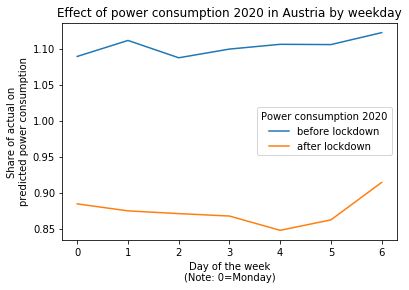

In [74]:
power_demand_for_2020['day_of_week'] = power_demand_for_2020.index.day_name()
power_demand_for_2020['obs_vs_pred'] = power_demand_for_2020.TotalLoadValue / power_demand_for_2020.prediction_2020

before_lockdown = power_demand_for_2020[power_demand_for_2020.index <= '2020-03-15']
after_lockdown = power_demand_for_2020[power_demand_for_2020.index > '2020-03-15']

mean_diff_pred_vs_obs = after_lockdown.obs_vs_pred.groupby(after_lockdown.index.weekday).mean()
print(mean_diff_pred_vs_obs[mean_diff_pred_vs_obs == mean_diff_pred_vs_obs.min()])


before_lockdown.obs_vs_pred.groupby(before_lockdown.index.weekday).mean().plot(label="before lockdown")
after_lockdown.obs_vs_pred.groupby(after_lockdown.index.weekday).mean().plot(label= "after lockdown")
plt.legend(title="Power consumption 2020")
plt.xlabel("Day of the week\n(Note: 0=Monday)")
plt.ylabel("Share of actual on\npredicted power consumption")
plt.title("Effect of power consumption 2020 in Austria by weekday")

## Exercise 5

Download ERA5 temperature data for the next lecture.

First install necessary dependencies `xarray` and `cdsapi`:

In [ ]:
conda install --yes xarray
conda install --yes -c conda-forge cdsapi

The [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/) provides [reanalysis climate data](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20))). We are going to download [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=form) data and use the [temperature 2m above ground values](https://apps.ecmwf.int/codes/grib/param-db?id=167).

Register for the CDS API and install the API key by following [this guide](https://cds.climate.copernicus.eu/api-how-to). You don't need to run `pip install cdsapi`, this has been done in the cell above already using conda.

In [23]:
import cdsapi

c = cdsapi.Client()

In [24]:
# Add the path to the lecture repository here:
PATH_TO_LECTURE_REPO = 'C:/Users/Aleks/lecture-scientific-computing'

if not os.path.isdir(Path(PATH_TO_LECTURE_REPO) / 'lecture00-introduction'):
    raise RuntimeError(f"Wrong path to lecture repository: PATH_TO_LECTURE_REPO = {PATH_TO_LECTURE_REPO}")

We'll download data from 2015 to 2020 in a bounding box which covers all countries we used so far for our analysis.
To make the download a bit faster, we'll use a [0.5° grid](https://confluence.ecmwf.int/display/CKB/ERA5%3A+Web+API+to+CDS+API) instead of the 0.1° grid. This will download approximately 500MB. The download might take a couple of hours, because the data is prepared on their servers before it can be downloaded.

In [25]:
filename = Path(PATH_TO_LECTURE_REPO) / 'data' / 'temperatures_era5.nc'

north, west, south, east = 70.,-13.5, 35.5, 24.5

c.retrieve(
    'reanalysis-era5-land',
    {
        'format': 'netcdf',
        'variable': '2m_temperature',
        'area': [
            north, west, south, east
        ],
        'grid': [0.5, 0.5],  # grid in 0.5deg steps in longitude/latitude
        'day': [f"{day:02d}" for day in range(1, 32)],
        'time': [f"{hour:02d}:00" for hour in range(24)],
        'month': [f"{month:02d}" for month in range(1, 13)],
        'year': [str(year) for year in range(2015, 2021)],
    },
    f"{filename}.part")

# this prevents you from accidentally using broken files:
os.rename(f"{filename}.part", filename)

2020-06-03 13:17:26,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2020-06-03 13:17:26,900 INFO Request is queued
2020-06-03 13:17:31,850 INFO Request is running
2020-06-03 15:31:59,595 INFO Request is completed
2020-06-03 15:31:59,608 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data2/adaptor.mars.internal-1591183051.143155-14109-29-85466677-b2b7-422c-8304-0a46d57630dc.nc to C:\Users\Aleks\lecture-scientific-computing\data\temperatures_era5.nc.part (473.2M)
2020-06-03 15:38:42,496 INFO Download rate 1.2M/s  


## Exercise 6

Load the file downloaded in exercise 3 and plot the temperature for one location. This is also a test if the download was successful. To load the file import the library `xarray`. Typically it is imported by using `import xarray as xr`. Then load the file using the command `xr.load_dataset(filename)`. Check the type of the return value. Then select the data variable `t2m` (temperature at 2m), select the values for `longitude=16.5` and `latitude=48` by using `temperatures_dataset.t2m.sel(longitude=16.5, latitude=48.)`. Then plot the result by calling `.plot()` on the resulting object.

Does the result look reasonable?

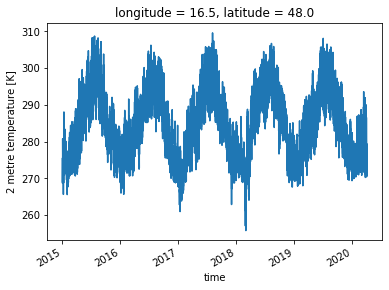

In [60]:
import xarray as xr

temp_data = xr.load_dataset('C:/.. /data/temperatures_era5.nc')
our_temp = temp_data.t2m.sel(longitude = 16.5, latitude = 48.)

our_temp.plot()